In [2]:
import os
import os.path
import os.path as op
from keras import backend as K

In [3]:
import tensorflow as tf

In [4]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2  

In [51]:
pwd

'/Users/seimandijuliette/git/asd-project/data'

In [55]:
import os
import numpy as np
import shutil
import random

# # Creating Train / Val / Test folders (One time use)
root_dir = 'images/new_images'
classes_dir = ['/autism', '/control']

val_ratio = 0.8
test_ratio = 0.2

for cls in classes_dir:
    os.makedirs(root_dir +'/train' + cls)
    os.makedirs(root_dir +'/test' + cls)


    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + cls)

Total images:  529
Training:  423
Testing:  106
Total images:  571
Training:  456
Testing:  115


In [ ]:
Data Augmentation

In [6]:

# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('images/new_images/train/',
                                       class_mode = 'categorical',
                                       target_size = (224, 224))
test_it = datagen.flow_from_directory('images/new_images/test/', 
                                      class_mode = 'categorical',
                                      target_size = (224, 224))
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 879 images belonging to 2 classes.
Found 221 images belonging to 2 classes.
Batch shape=(32, 224, 224, 3), min=0.000, max=250.087


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'images/new_images/train'  
validation_data_dir = 'images/new_images/test'  
   
 # number of epochs to train top model  
epochs = 50  
 # batch size used by flow_from_directory and predict_generator  
batch_size = 16  

In [8]:
 model = applications.VGG16(include_top=False, weights='imagenet')  

In [9]:
datagen = ImageDataGenerator(rescale=1. / 255)  
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = model.predict_generator(  
     generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)  

Found 879 images belonging to 2 classes.


/Users/seimandijuliette/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [11]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 


Found 879 images belonging to 2 classes.


In [10]:
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = model.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 

Found 221 images belonging to 2 classes.


In [12]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 221 images belonging to 2 classes.


In [13]:
model = Sequential() 

model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  
   
model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy']) 

In [14]:
history = model.fit(train_data, train_labels,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data, validation_labels))

Epoch 1/50
55/55 [==============================] - 3s 42ms/step - loss: 5.2953 - accuracy: 0.4864 - val_loss: 0.6961 - val_accuracy: 0.4796
Epoch 2/50
55/55 [==============================] - 2s 31ms/step - loss: 0.7150 - accuracy: 0.5110 - val_loss: 0.6931 - val_accuracy: 0.4842
Epoch 3/50
55/55 [==============================] - 2s 30ms/step - loss: 0.7298 - accuracy: 0.5056 - val_loss: 0.6930 - val_accuracy: 0.5204
Epoch 4/50
55/55 [==============================] - 2s 31ms/step - loss: 0.7042 - accuracy: 0.5169 - val_loss: 0.6888 - val_accuracy: 0.5204
Epoch 5/50
55/55 [==============================] - 2s 30ms/step - loss: 0.7027 - accuracy: 0.5442 - val_loss: 0.6924 - val_accuracy: 0.5204
Epoch 6/50
55/55 [==============================] - 2s 32ms/step - loss: 0.6933 - accuracy: 0.5384 - val_loss: 0.6878 - val_accuracy: 0.5204
Epoch 7/50
55/55 [==============================] - 2s 32ms/step - loss: 0.6997 - accuracy: 0.5535 - val_loss: 0.6903 - val_accuracy: 0.5656
Epoch 8/50
55

In [15]:
model.save_weights(top_model_weights_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(  
     validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

14/14 [==============================] - 0s 4ms/step - loss: 0.7514 - accuracy: 0.6018
[INFO] accuracy: 60.18%
[INFO] Loss: 0.751358151435852


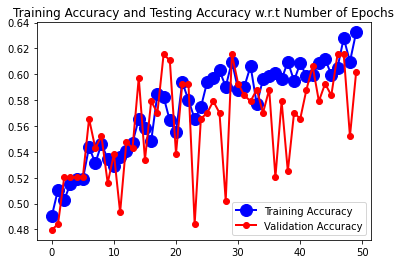

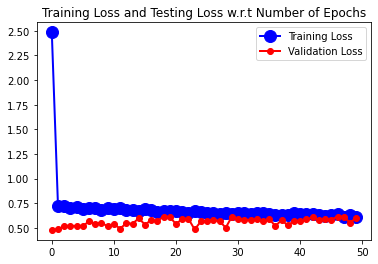

In [16]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
No_Of_Epochs = range(epochs)

plt.plot(No_Of_Epochs, train_acc, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Accuracy')
plt.plot(No_Of_Epochs, val_acc, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Accuracy')

plt.title('Training Accuracy and Testing Accuracy w.r.t Number of Epochs')

plt.legend()

plt.figure()

plt.plot(No_Of_Epochs, train_loss, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Loss')
plt.plot(No_Of_Epochs, val_acc, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Loss')

plt.title('Training Loss and Testing Loss w.r.t Number of Epochs')

plt.legend()

plt.show()

In [17]:
image_path = 'image_test/test_image1.jpg'  
   
orig = cv2.imread(image_path)  
   
print("[INFO] loading and preprocessing image...")  
image = load_img(image_path, target_size=(224, 224))  
image = img_to_array(image)  

# important! otherwise the predictions will be '0'  
image = image / 255  

image = np.expand_dims(image, axis=0)

[INFO] loading and preprocessing image...


In [18]:
# build the VGG16 network  
model = applications.VGG16(include_top=False, weights='imagenet')  

# get the bottleneck prediction from the pre-trained VGG16 model  
bottleneck_prediction = model.predict(image)  

# build top model  
model = Sequential()  
model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.load_weights(top_model_weights_path)  

# use the bottleneck prediction on the top model to get the final classification  
class_predicted = model.predict_classes(bottleneck_prediction)

/Users/seimandijuliette/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [19]:
inID = class_predicted[0]  

class_dictionary = generator_top.class_indices  

inv_map = {v: k for k, v in class_dictionary.items()}  

label = inv_map[inID]  

# get the prediction label  
print("Image ID: {}, Label: {}".format(inID, label))  

# display the predictions with the image  
cv2.putText(orig, "Predicted: {}".format(label), (10, 30), cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)  

cv2.imshow("Classification", orig)  

Image ID: 1, Label: control
